In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

# Paths
train_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/train'
val_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/valid'
test_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/test'

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

# Paths
train_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/train'
val_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/valid'
test_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/test'

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load MobileNetV2 without the top
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

# Custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Callbacks
checkpoint = ModelCheckpoint("mobilenetv2_ct_scan_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Step 1: Train top layers
print("\n🚀 Training top layers of MobileNetV2...")
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)

# Step 2: Fine-tune base model
print("\n🔧 Fine-tuning MobileNetV2 base model...")
base_model.trainable = True

# Optional: Freeze some layers if needed
for layer in base_model.layers[:50]:
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Fine-tune
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)

# Evaluate on test data
print("\n📊 Evaluating MobileNetV2 on test set...")
loss, accuracy, precision, recall = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"✅ Test Precision: {precision * 100:.2f}%")
print(f"✅ Test Recall: {recall * 100:.2f}%")


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.



🚀 Training top layers of MobileNetV2...
Epoch 1/150


2025-04-17 23:57:45.635050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 2.8353 - accuracy: 0.3980 - precision: 0.4063 - recall: 0.3785

2025-04-17 23:57:50.773214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to mobilenetv2_ct_scan_best.h5
20/20 [==============================] - 7s 299ms/step - loss: 2.8353 - accuracy: 0.3980 - precision: 0.4063 - recall: 0.3785 - val_loss: 1.3643 - val_accuracy: 0.4583 - val_precision: 0.5082 - val_recall: 0.4306
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 2.1303 - accuracy: 0.5220 - precision: 0.5371 - recall: 0.5073
Epoch 2: val_accuracy improved from 0.45833 to 0.55556, saving model to mobilenetv2_ct_scan_best.h5
20/20 [==============================] - 5s 247ms/step - loss: 2.1303 - accuracy: 0.5220 - precision: 0.5371 - recall: 0.5073 - val_loss: 1.2121 - val_accuracy: 0.5556 - val_precision: 0.5606 - val_recall: 0.5139
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 1.6066 - accuracy: 0.5432 - precision: 0.5571 - recall: 0.5253
Epoch 3: val_accuracy did not improve from 0.55556
20/20 [==============================] - 5s 243ms/step - loss


🔧 Fine-tuning MobileNetV2 base model...
Epoch 1/150


2025-04-18 00:04:54.088610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 4.1519 - accuracy: 0.3752 - precision: 0.3737 - recall: 0.3573

2025-04-18 00:05:02.551593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.79167
20/20 [==============================] - 11s 386ms/step - loss: 4.1519 - accuracy: 0.3752 - precision: 0.3737 - recall: 0.3573 - val_loss: 0.7391 - val_accuracy: 0.7917 - val_precision: 0.7941 - val_recall: 0.7500
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 2.8727 - accuracy: 0.4454 - precision: 0.4609 - recall: 0.4323
Epoch 2: val_accuracy did not improve from 0.79167
20/20 [==============================] - 6s 302ms/step - loss: 2.8727 - accuracy: 0.4454 - precision: 0.4609 - recall: 0.4323 - val_loss: 0.7719 - val_accuracy: 0.7917 - val_precision: 0.7971 - val_recall: 0.7639
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 1.8870 - accuracy: 0.5514 - precision: 0.5557 - recall: 0.5204
Epoch 3: val_accuracy did not improve from 0.79167
20/20 [==============================] - 6s 306ms/step - loss: 1.8870 - accuracy: 0.5514 - precision: 0.5557 - recall: 0.5204 - val_loss: 0.7949 - val_accu

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

# Paths
train_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/train'
val_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/valid'
test_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/test'

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load DenseNet121 without top
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Callbacks
checkpoint = ModelCheckpoint("densenet121_ct_scan_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Step 1: Train top layers
print("\n🚀 Training top layers of DenseNet121...")
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)

# Step 2: Fine-tuning the base model
print("\n🔧 Fine-tuning DenseNet121 base model...")
base_model.trainable = True

# Optional: Freeze the first N layers if desired
for layer in base_model.layers[:50]:
    layer.trainable = False

# Re-compile with lower learning rate
model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Continue training (fine-tuning)
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)

# Evaluate
print("\n📊 Evaluating DenseNet121 on test set...")
loss, accuracy, precision, recall = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"✅ Test Precision: {precision * 100:.2f}%")
print(f"✅ Test Recall: {recall * 100:.2f}%")


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.



🚀 Training top layers of DenseNet121...
Epoch 1/150


2025-04-18 00:08:41.474246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 2.4559 - accuracy: 0.3458 - precision: 0.3606 - recall: 0.3165

2025-04-18 00:08:49.619655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.36111, saving model to densenet121_ct_scan_best.h5
20/20 [==============================] - 13s 485ms/step - loss: 2.4559 - accuracy: 0.3458 - precision: 0.3606 - recall: 0.3165 - val_loss: 1.4853 - val_accuracy: 0.3611 - val_precision: 0.4000 - val_recall: 0.3056
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 1.6844 - accuracy: 0.4535 - precision: 0.4685 - recall: 0.4127
Epoch 2: val_accuracy improved from 0.36111 to 0.51389, saving model to densenet121_ct_scan_best.h5
20/20 [==============================] - 6s 310ms/step - loss: 1.6844 - accuracy: 0.4535 - precision: 0.4685 - recall: 0.4127 - val_loss: 1.5335 - val_accuracy: 0.5139 - val_precision: 0.5294 - val_recall: 0.5000
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 1.3635 - accuracy: 0.5139 - precision: 0.5276 - recall: 0.4682
Epoch 3: val_accuracy did not improve from 0.51389
20/20 [==============================] - 7s 325ms/step - los


🔧 Fine-tuning DenseNet121 base model...
Epoch 1/150


2025-04-18 00:13:59.331454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 4.0151 - accuracy: 0.3622 - precision: 0.3667 - recall: 0.3589

2025-04-18 00:14:26.952626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.73611
20/20 [==============================] - 36s 1s/step - loss: 4.0151 - accuracy: 0.3622 - precision: 0.3667 - recall: 0.3589 - val_loss: 0.7615 - val_accuracy: 0.6944 - val_precision: 0.7231 - val_recall: 0.6528
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 2.7605 - accuracy: 0.3964 - precision: 0.4084 - recall: 0.3817
Epoch 2: val_accuracy did not improve from 0.73611
20/20 [==============================] - 22s 1s/step - loss: 2.7605 - accuracy: 0.3964 - precision: 0.4084 - recall: 0.3817 - val_loss: 0.8180 - val_accuracy: 0.6250 - val_precision: 0.6667 - val_recall: 0.5833
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 1.9829 - accuracy: 0.4796 - precision: 0.4884 - recall: 0.4454
Epoch 3: val_accuracy did not improve from 0.73611
20/20 [==============================] - 22s 1s/step - loss: 1.9829 - accuracy: 0.4796 - precision: 0.4884 - recall: 0.4454 - val_loss: 0.8432 - val_accuracy: 0

In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

# Paths
train_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/train'
val_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/valid'
test_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/test'

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load base ResNet50 model (excluding top)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base initially

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Callbacks
checkpoint = ModelCheckpoint("resnet50_ct_scan_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Step 1: Train top layers
print("\n🚀 Training top layers of ResNet50...")
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)

# Step 2: Fine-tuning - unfreeze some layers
print("\n🔧 Fine-tuning ResNet50 base model...")
base_model.trainable = True

# (Optional) Freeze first few layers if needed
for layer in base_model.layers[:50]:
    layer.trainable = False

# Re-compile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Continue training (fine-tuning)
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)

# Evaluation
print("\n📊 Evaluating ResNet50 on test set...")
loss, accuracy, precision, recall = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"✅ Test Precision: {precision * 100:.2f}%")
print(f"✅ Test Recall: {recall * 100:.2f}%")


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.



🚀 Training top layers of ResNet50...
Epoch 1/150


2025-04-18 02:28:17.431062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 1.7788 - accuracy: 0.3034 - precision: 0.3203 - recall: 0.1876

2025-04-18 02:28:23.900571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.47222, saving model to resnet50_ct_scan_best.h5
20/20 [==============================] - 12s 376ms/step - loss: 1.7788 - accuracy: 0.3034 - precision: 0.3203 - recall: 0.1876 - val_loss: 1.3230 - val_accuracy: 0.4722 - val_precision: 0.4516 - val_recall: 0.1944
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 1.5686 - accuracy: 0.3801 - precision: 0.4278 - recall: 0.2512
Epoch 2: val_accuracy did not improve from 0.47222
20/20 [==============================] - 6s 284ms/step - loss: 1.5686 - accuracy: 0.3801 - precision: 0.4278 - recall: 0.2512 - val_loss: 1.4652 - val_accuracy: 0.4028 - val_precision: 0.6667 - val_recall: 0.2222
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 1.5601 - accuracy: 0.3328 - precision: 0.3507 - recall: 0.1974
Epoch 3: val_accuracy did not improve from 0.47222
20/20 [==============================] - 6s 302ms/step - loss: 1.5601 - accuracy: 0.3328 - precision: 0.3507 - r


🔧 Fine-tuning ResNet50 base model...
Epoch 1/150


2025-04-18 02:32:08.653994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 21.0768 - accuracy: 0.2414 - precision: 0.2414 - recall: 0.2414

2025-04-18 02:32:26.921663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.51389
20/20 [==============================] - 24s 1s/step - loss: 21.0768 - accuracy: 0.2414 - precision: 0.2414 - recall: 0.2414 - val_loss: 2.5690 - val_accuracy: 0.1806 - val_precision: 0.1806 - val_recall: 0.1806
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 9.2579 - accuracy: 0.2545 - precision: 0.2512 - recall: 0.2463
Epoch 2: val_accuracy did not improve from 0.51389
20/20 [==============================] - 17s 834ms/step - loss: 9.2579 - accuracy: 0.2545 - precision: 0.2512 - recall: 0.2463 - val_loss: 9.5928 - val_accuracy: 0.1806 - val_precision: 0.1806 - val_recall: 0.1806
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 2.4422 - accuracy: 0.3687 - precision: 0.3758 - recall: 0.3034
Epoch 3: val_accuracy did not improve from 0.51389
20/20 [==============================] - 16s 786ms/step - loss: 2.4422 - accuracy: 0.3687 - precision: 0.3758 - recall: 0.3034 - val_loss: 17.7303 - val_acc

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

# Paths
train_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/train'
val_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/valid'
test_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/test'

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load pre-trained VGG19 (exclude top)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model initially
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Callbacks
checkpoint = ModelCheckpoint("vgg19_ct_scan_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the top layers
print("\n🚀 Training top layers of VGG19...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)

# Fine-tuning: Unfreeze some layers
print("\n🔧 Fine-tuning VGG19 base model...")
base_model.trainable = True

# (Optional) Freeze first few layers to avoid overfitting
for layer in base_model.layers[:10]:
    layer.trainable = False

# Recompile after changing trainable status
model.compile(
    optimizer=Adam(1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Fine-tune the model
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    callbacks=[checkpoint, early_stop]
)

# Evaluate
print("\n📊 Evaluating on test set...")
loss, accuracy, precision, recall = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"✅ Test Precision: {precision * 100:.2f}%")
print(f"✅ Test Recall: {recall * 100:.2f}%")


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


2025-04-17 21:30:03.197155: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-17 21:30:03.197178: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-17 21:30:03.197188: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-17 21:30:03.197566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-17 21:30:03.197846: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


80134624/80134624 [==============================] - 31s 0us/step



🚀 Training top layers of VGG19...
Epoch 1/150


2025-04-17 21:30:36.444637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 1.6552 - accuracy: 0.2773 - precision: 0.2731 - recall: 0.1207

2025-04-17 21:30:44.435067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.37500, saving model to vgg19_ct_scan_best.h5
20/20 [==============================] - 9s 419ms/step - loss: 1.6552 - accuracy: 0.2773 - precision: 0.2731 - recall: 0.1207 - val_loss: 1.2885 - val_accuracy: 0.3750 - val_precision: 1.0000 - val_recall: 0.0278
Epoch 2/150


/Users/unar/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - ETA: 0s - loss: 1.3562 - accuracy: 0.3458 - precision: 0.4205 - recall: 0.1338
Epoch 2: val_accuracy improved from 0.37500 to 0.43056, saving model to vgg19_ct_scan_best.h5
20/20 [==============================] - 8s 411ms/step - loss: 1.3562 - accuracy: 0.3458 - precision: 0.4205 - recall: 0.1338 - val_loss: 1.2075 - val_accuracy: 0.4306 - val_precision: 1.0000 - val_recall: 0.0278
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 1.2379 - accuracy: 0.4241 - precision: 0.5602 - recall: 0.1517
Epoch 3: val_accuracy improved from 0.43056 to 0.48611, saving model to vgg19_ct_scan_best.h5
20/20 [==============================] - 9s 471ms/step - loss: 1.2379 - accuracy: 0.4241 - precision: 0.5602 - recall: 0.1517 - val_loss: 1.1549 - val_accuracy: 0.4861 - val_precision: 0.6471 - val_recall: 0.1528
Epoch 4/150
20/20 [==============================] - ETA: 0s - loss: 1.1650 - accuracy: 0.4600 - precision: 0.6527 - recall: 0.1778
Ep


🔧 Fine-tuning VGG19 base model...
Epoch 1/150


2025-04-17 22:09:59.158999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.7502 - accuracy: 0.7162 - precision: 0.7395 - recall: 0.6900

2025-04-17 22:10:41.267989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.77778
20/20 [==============================] - 45s 2s/step - loss: 0.7502 - accuracy: 0.7162 - precision: 0.7395 - recall: 0.6900 - val_loss: 0.5767 - val_accuracy: 0.7361 - val_precision: 0.7778 - val_recall: 0.6806
Epoch 2/150
20/20 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.7749 - precision: 0.7983 - recall: 0.7553
Epoch 2: val_accuracy did not improve from 0.77778
20/20 [==============================] - 39s 2s/step - loss: 0.5547 - accuracy: 0.7749 - precision: 0.7983 - recall: 0.7553 - val_loss: 0.6507 - val_accuracy: 0.7083 - val_precision: 0.7143 - val_recall: 0.6944
Epoch 3/150
20/20 [==============================] - ETA: 0s - loss: 0.4020 - accuracy: 0.8336 - precision: 0.8576 - recall: 0.8059
Epoch 3: val_accuracy improved from 0.77778 to 0.83333, saving model to vgg19_ct_scan_best.h5
20/20 [==============================] - 36s 2s/step - loss: 0.4020 - accuracy: 0.8336 - precision: 0.8576 - recall: 

In [2]:
from tensorflow.keras.models import load_model

# Load the best saved model
model_VGG = load_model('vgg19_ct_scan_best.h5')

# Evaluate


2025-04-17 22:56:40.494842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 492ms/step


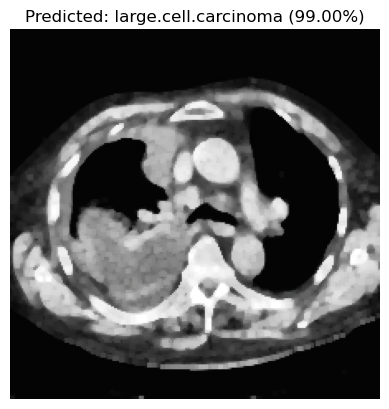

In [3]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- Custom Preprocessing Functions ---
def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  # Image is in RGB from Keras
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# --- Load Image and Preprocess ---
img_path = '/Users/unar/Downloads/LLDS.png'  # Your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img).astype(np.uint8)
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Ensuring RGB

# Apply preprocessing pipeline
processed_img = apply_median_filter(img_rgb)
processed_img = apply_histogram_equalization(processed_img)
processed_img = apply_clahe(processed_img)
processed_img = apply_morphological_ops(processed_img)

# Normalize and prepare for model
processed_img = processed_img / 255.0
img_batch = np.expand_dims(processed_img, axis=0)

# --- Predict ---
prediction = model_VGG.predict(img_batch)
predicted_class_index = np.argmax(prediction)
class_labels = list(train_gen.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

# --- Display ---
plt.imshow(processed_img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({np.max(prediction)*100:.2f}%)")
plt.show()

1/1 [==============================] - 0s 16ms/step


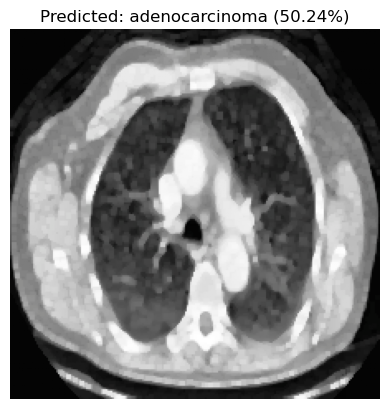

In [4]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- Custom Preprocessing Functions ---
def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  # Image is in RGB from Keras
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# --- Load Image and Preprocess ---
img_path = '/Users/unar/Downloads/AD.png'  # Your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img).astype(np.uint8)
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Ensuring RGB

# Apply preprocessing pipeline
processed_img = apply_median_filter(img_rgb)
processed_img = apply_histogram_equalization(processed_img)
processed_img = apply_clahe(processed_img)
processed_img = apply_morphological_ops(processed_img)

# Normalize and prepare for model
processed_img = processed_img / 255.0
img_batch = np.expand_dims(processed_img, axis=0)

# --- Predict ---
prediction = model_VGG.predict(img_batch)
predicted_class_index = np.argmax(prediction)
class_labels = list(train_gen.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

# --- Display ---
plt.imshow(processed_img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({np.max(prediction)*100:.2f}%)")
plt.show()

1/1 [==============================] - 0s 13ms/step


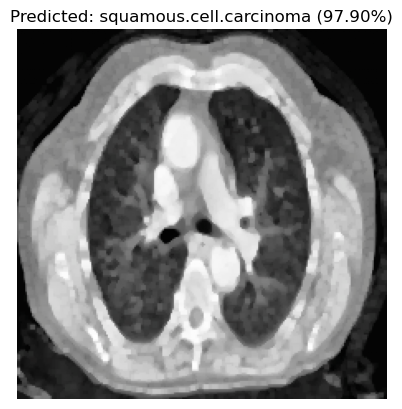

In [5]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- Custom Preprocessing Functions ---
def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  # Image is in RGB from Keras
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# --- Load Image and Preprocess ---
img_path = '/Users/unar/Downloads/SC.png'  # Your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img).astype(np.uint8)
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Ensuring RGB

# Apply preprocessing pipeline
processed_img = apply_median_filter(img_rgb)
processed_img = apply_histogram_equalization(processed_img)
processed_img = apply_clahe(processed_img)
processed_img = apply_morphological_ops(processed_img)

# Normalize and prepare for model
processed_img = processed_img / 255.0
img_batch = np.expand_dims(processed_img, axis=0)

# --- Predict ---
prediction = model_VGG.predict(img_batch)
predicted_class_index = np.argmax(prediction)
class_labels = list(train_gen.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

# --- Display ---
plt.imshow(processed_img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({np.max(prediction)*100:.2f}%)")
plt.show()

1/1 [==============================] - 0s 10ms/step


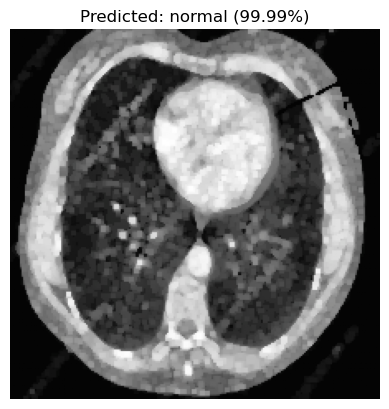

In [6]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- Custom Preprocessing Functions ---
def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  # Image is in RGB from Keras
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# --- Load Image and Preprocess ---
img_path = '/Users/unar/Downloads/NRL.png'  # Your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img).astype(np.uint8)
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Ensuring RGB

# Apply preprocessing pipeline
processed_img = apply_median_filter(img_rgb)
processed_img = apply_histogram_equalization(processed_img)
processed_img = apply_clahe(processed_img)
processed_img = apply_morphological_ops(processed_img)

# Normalize and prepare for model
processed_img = processed_img / 255.0
img_batch = np.expand_dims(processed_img, axis=0)

# --- Predict ---
prediction = model_VGG.predict(img_batch)
predicted_class_index = np.argmax(prediction)
class_labels = list(train_gen.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

# --- Display ---
plt.imshow(processed_img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({np.max(prediction)*100:.2f}%)")
plt.show()